# Image Search Evaluation Analysis

This notebook analyzes the evaluation results and compares different model configurations.

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Load and Process Results

In [2]:
# Load raw results
df = pd.read_csv('data/evaluation/results.csv')

print(f"Total rows: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Total rows: 360

Columns: ['model', 'enhancement', 'difficulty', 'query_id', 'k', 'results']

First few rows:


,model,enhancement,difficulty,query_id,k,results
0,clip,True,eq,eq1,15,"[""eq2_13"", ""eq1_13"", ""eq1_11"", ""eq1_3"", ""eq1_1..."
1,clip,True,eq,eq1,8,"[""eq2_13"", ""eq1_13"", ""eq1_11"", ""eq1_3"", ""eq1_1..."
2,clip,True,eq,eq1,1,"[""eq2_13""]"
3,clip,True,eq,eq2,15,"[""eq2_11"", ""eq2_3"", ""eq2_9"", ""eq2_13"", ""eq2_14..."
4,clip,True,eq,eq2,8,"[""eq2_11"", ""eq2_3"", ""eq2_9"", ""eq2_13"", ""eq2_14..."


## Calculate Recall@K and Create Aggregated Results

In [3]:
def calculate_recall(row):
    """
    Calculate recall@k for a single query.
    
    Recall@k = (number of results containing query_id) / k
    """
    query_id = row['query_id']
    results = json.loads(row['results'])
    k = row['k']
    
    # Count how many results contain the query_id as substring
    true_positives = sum(1 for result in results if query_id in result)
    
    # Calculate recall
    recall = true_positives / k if k > 0 else 0
    
    return recall


def map_k_to_label(row):
    """
    Map k values to labels based on difficulty.
    
    Easy (eq): 15→'all', 8→'half', 1→'top'
    Medium (mq): 10→'all', 5→'half', 1→'top'
    Hard (hq): 5→'all', 3→'half', 1→'top'
    """
    difficulty = row['difficulty']
    k = row['k']
    
    k_mapping = {
        'eq': {15: 'all', 8: 'half', 1: 'top'},
        'mq': {10: 'all', 5: 'half', 1: 'top'},
        'hq': {5: 'all', 3: 'half', 1: 'top'}
    }
    
    return k_mapping.get(difficulty, {}).get(k, str(k))


# Calculate recall for each row
print("Calculating recall@k for each query...")
df['recall'] = df.apply(calculate_recall, axis=1)

# Map k values to labels
df['k_label'] = df.apply(map_k_to_label, axis=1)

print(f"✓ Calculated recall for {len(df)} queries")
print(f"\nRecall statistics:")
print(df['recall'].describe())

Calculating recall@k for each query...
✓ Calculated recall for 360 queries

Recall statistics:
count    360.000000
mean       0.664398
std        0.356786
min        0.000000
25%        0.400000
50%        0.800000
75%        1.000000
max        1.000000
Name: recall, dtype: float64


In [4]:
# Group by configuration and calculate average recall and std
print("Aggregating results by configuration...")

aggregated = df.groupby(['model', 'enhancement', 'difficulty', 'k_label']).agg({
    'recall': ['mean', 'std']
}).reset_index()

# Flatten column names
aggregated.columns = ['model', 'enhancement', 'difficulty', 'k', 'avg_recall', 'std']

# Map difficulty codes to full names
difficulty_mapping = {
    'eq': 'easy',
    'mq': 'medium',
    'hq': 'hard'
}
aggregated['difficulty'] = aggregated['difficulty'].map(difficulty_mapping)

# Rename models for better readability
model_name_mapping = {
    'clip': 'clip',
    'clip_rerank_a0.4': 'reranked_clip (a=0.4)',
    'clip_rerank_a0.6': 'reranked_clip (a=0.6)',
    'clip_rerank_a1.0': 'reranked_clip (a=1.0)'
}
aggregated['model'] = aggregated['model'].map(model_name_mapping)

# Define proper ordering
difficulty_order = {'easy': 0, 'medium': 1, 'hard': 2}
k_order = {'all': 0, 'half': 1, 'top': 2}

aggregated['difficulty_order'] = aggregated['difficulty'].map(difficulty_order)
aggregated['k_order'] = aggregated['k'].map(k_order)

# Sort by model, enhancement, difficulty, k
aggregated = aggregated.sort_values(['model', 'enhancement', 'difficulty_order', 'k_order'])

# Drop ordering columns
aggregated = aggregated.drop(['difficulty_order', 'k_order'], axis=1)

# Reset index
aggregated = aggregated.reset_index(drop=True)

print(f"✓ Created {len(aggregated)} configuration results")
print(f"\nConfigurations per model:")
print(aggregated['model'].value_counts())

aggregated.head(10)

Aggregating results by configuration...
✓ Created 72 configuration results

Configurations per model:
model
clip                     18
reranked_clip (a=0.4)    18
reranked_clip (a=0.6)    18
reranked_clip (a=1.0)    18
Name: count, dtype: int64


,model,enhancement,difficulty,k,avg_recall,std
0,clip,False,easy,all,0.600000,0.115470
1,clip,False,easy,half,0.725000,0.240442
2,clip,False,easy,top,0.600000,0.547723
3,clip,False,medium,all,0.460000,0.288097
4,clip,False,medium,half,0.520000,0.363318
5,clip,False,medium,top,0.800000,0.447214
6,clip,False,hard,all,0.400000,0.424264
7,clip,False,hard,half,0.466667,0.505525
8,clip,False,hard,top,0.400000,0.547723
9,clip,True,easy,all,0.786667,0.128236


In [5]:
# Save aggregated results
import os

output_path = 'data/evaluation/models_evaluation_results.csv'

# Ensure directory exists
os.makedirs('data/evaluation', exist_ok=True)

# Save to CSV
aggregated.to_csv(output_path, index=False)

print(f"✓ Saved aggregated results to: {output_path}")
print(f"  File exists: {os.path.exists(output_path)}")
print(f"  File size: {os.path.getsize(output_path)} bytes")
print(f"\nSummary:")
print(f"  Total configurations: {len(aggregated)}")
print(f"  Models: {aggregated['model'].unique().tolist()}")
print(f"  Enhancement settings: {sorted(aggregated['enhancement'].unique().tolist())}")
print(f"  Difficulties: {sorted(aggregated['difficulty'].unique().tolist())}")
print(f"  K values: {sorted(aggregated['k'].unique().tolist())}")

✓ Saved aggregated results to: data/evaluation/models_evaluation_results.csv
  File exists: True
  File size: 4342 bytes

Summary:
  Total configurations: 72
  Models: ['clip', 'reranked_clip (a=0.4)', 'reranked_clip (a=0.6)', 'reranked_clip (a=1.0)']
  Enhancement settings: [False, True]
  Difficulties: ['easy', 'hard', 'medium']
  K values: ['all', 'half', 'top']


## Preview Results

In [6]:
# Display sample of results
print("Sample of aggregated results:")
print("="*80)

# Show a few configurations
for model in aggregated['model'].unique()[:2]:  # First 2 models
    print(f"\n{model}:")
    sample = aggregated[aggregated['model'] == model].head(9)
    print(sample.to_string(index=False))
    print()

Sample of aggregated results:

clip:
model  enhancement difficulty    k  avg_recall      std
 clip        False       easy  all    0.600000 0.115470
 clip        False       easy half    0.725000 0.240442
 clip        False       easy  top    0.600000 0.547723
 clip        False     medium  all    0.460000 0.288097
 clip        False     medium half    0.520000 0.363318
 clip        False     medium  top    0.800000 0.447214
 clip        False       hard  all    0.400000 0.424264
 clip        False       hard half    0.466667 0.505525
 clip        False       hard  top    0.400000 0.547723


reranked_clip (a=0.4):
                model  enhancement difficulty    k  avg_recall      std
reranked_clip (a=0.4)        False       easy  all    0.640000 0.089443
reranked_clip (a=0.4)        False       easy half    0.800000 0.068465
reranked_clip (a=0.4)        False       easy  top    0.800000 0.447214
reranked_clip (a=0.4)        False     medium  all    0.460000 0.336155
reranked_clip (a=0

In [7]:
# Show overall statistics
print("\nOverall Statistics by Model:")
print("="*80)

model_stats = aggregated.groupby('model').agg({
    'avg_recall': ['mean', 'std', 'min', 'max']
}).round(4)

model_stats.columns = ['Mean Recall', 'Std Dev', 'Min Recall', 'Max Recall']
print(model_stats)


Overall Statistics by Model:
                       Mean Recall  Std Dev  Min Recall  Max Recall
model                                                              
clip                        0.6439   0.1609        0.40       0.925
reranked_clip (a=0.4)       0.6886   0.1584        0.40       1.000
reranked_clip (a=0.6)       0.6770   0.1522        0.40       1.000
reranked_clip (a=1.0)       0.6481   0.1599        0.36       1.000


## Model Comparison (Without Query Enhancement)

✓ Saved chart to: data/evaluation/overall_comparison_no_enhancement.png


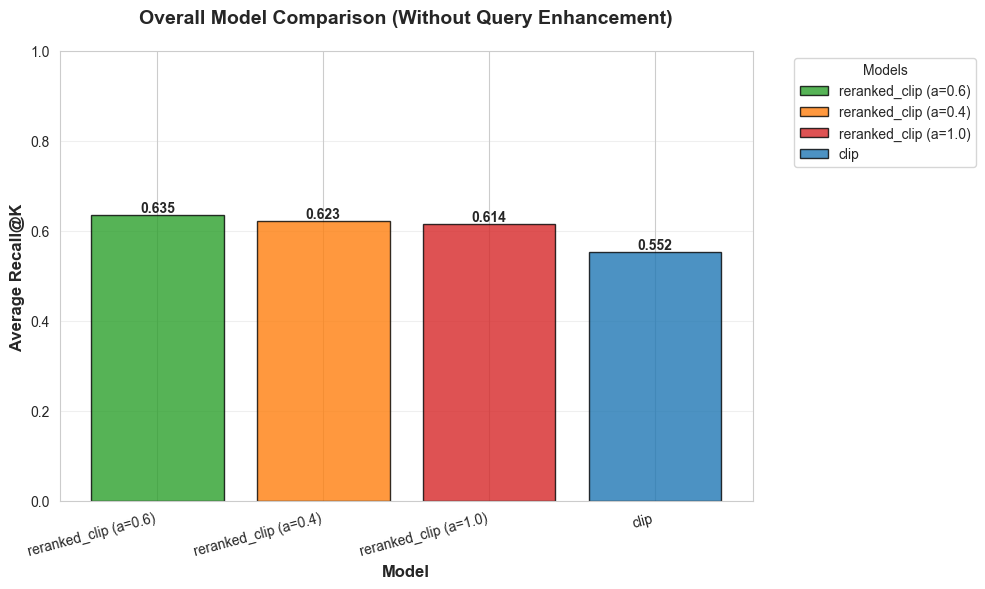


Overall Average Recall@K (without enhancement):
                model  avg_recall
reranked_clip (a=0.6)    0.635370
reranked_clip (a=0.4)    0.622963
reranked_clip (a=1.0)    0.614259
                 clip    0.552407


In [8]:
# Overall Model Comparison (Without Enhancement)
# Average recall@k across ALL difficulties and k values

# Filter for no enhancement
no_enhancement = aggregated[aggregated['enhancement'] == False].copy()

# Calculate overall average for each model
overall_avg = no_enhancement.groupby('model')['avg_recall'].mean().reset_index()
overall_avg = overall_avg.sort_values('avg_recall', ascending=False)

# Define consistent colors for models
model_colors = {
    'clip': '#1f77b4',
    'reranked_clip (a=0.4)': '#ff7f0e', 
    'reranked_clip (a=0.6)': '#2ca02c',
    'reranked_clip (a=1.0)': '#d62728'
}
colors = [model_colors[model] for model in overall_avg['model']]

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(overall_avg['model'], overall_avg['avg_recall'], color=colors, alpha=0.8, edgecolor='black')

# Add value labels on bars (set show_values=False to hide)
show_values = True
if show_values:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Formatting
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Recall@K', fontsize=12, fontweight='bold')
ax.set_title('Overall Model Comparison (Without Query Enhancement)', fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=15, ha='right')

# Add legend outside plot
legend_labels = [f'{model}' for model in overall_avg['model']]
ax.legend(bars, legend_labels, title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Save figure
output_path = 'data/evaluation/overall_comparison_no_enhancement.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved chart to: {output_path}")

plt.show()

# Print summary
print("\nOverall Average Recall@K (without enhancement):")
print(overall_avg.to_string(index=False))

✓ Saved chart to: data/evaluation/difficulty_comparison_no_enhancement.png


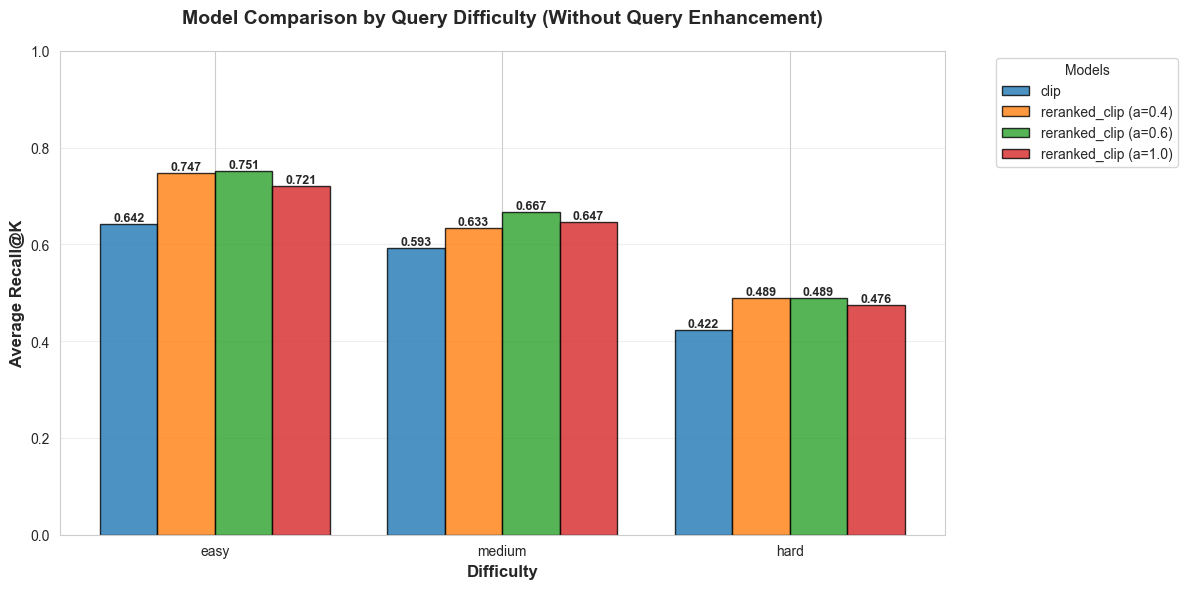


Average Recall@K by Difficulty (without enhancement):
model        clip  reranked_clip (a=0.4)  reranked_clip (a=0.6)  \
difficulty                                                        
easy        0.642                  0.747                  0.751   
medium      0.593                  0.633                  0.667   
hard        0.422                  0.489                  0.489   

model       reranked_clip (a=1.0)  
difficulty                         
easy                        0.721  
medium                      0.647  
hard                        0.476  


In [9]:
# Model Comparison by Difficulty (Without Enhancement)
# Compare models across easy, medium, and hard queries

# Calculate average recall for each model-difficulty combination
difficulty_avg = no_enhancement.groupby(['model', 'difficulty'])['avg_recall'].mean().reset_index()

# Pivot for plotting
difficulty_pivot = difficulty_avg.pivot(index='difficulty', columns='model', values='avg_recall')

# Ensure proper ordering
difficulty_order = ['easy', 'medium', 'hard']
difficulty_pivot = difficulty_pivot.reindex(difficulty_order)

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(difficulty_order))
width = 0.2
models = ['clip', 'reranked_clip (a=0.4)', 'reranked_clip (a=0.6)', 'reranked_clip (a=1.0)']

# Plot bars for each model
bars_list = []
for i, model in enumerate(models):
    values = [difficulty_pivot.loc[diff, model] for diff in difficulty_order]
    bars = ax.bar(x + i*width, values, width, 
                   label=model, color=model_colors[model], 
                   alpha=0.8, edgecolor='black')
    bars_list.append(bars)
    
    # Add value labels on bars (set show_values=False to hide)
    show_values = True
    if show_values:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

# Formatting
ax.set_xlabel('Difficulty', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Recall@K', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison by Query Difficulty (Without Query Enhancement)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(difficulty_order)
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)

# Add legend outside plot
ax.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Save figure
output_path = 'data/evaluation/difficulty_comparison_no_enhancement.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved chart to: {output_path}")

plt.show()

# Print summary table
print("\nAverage Recall@K by Difficulty (without enhancement):")
print(difficulty_pivot.round(3))

✓ Saved chart to: data/evaluation/k_value_comparison_no_enhancement.png


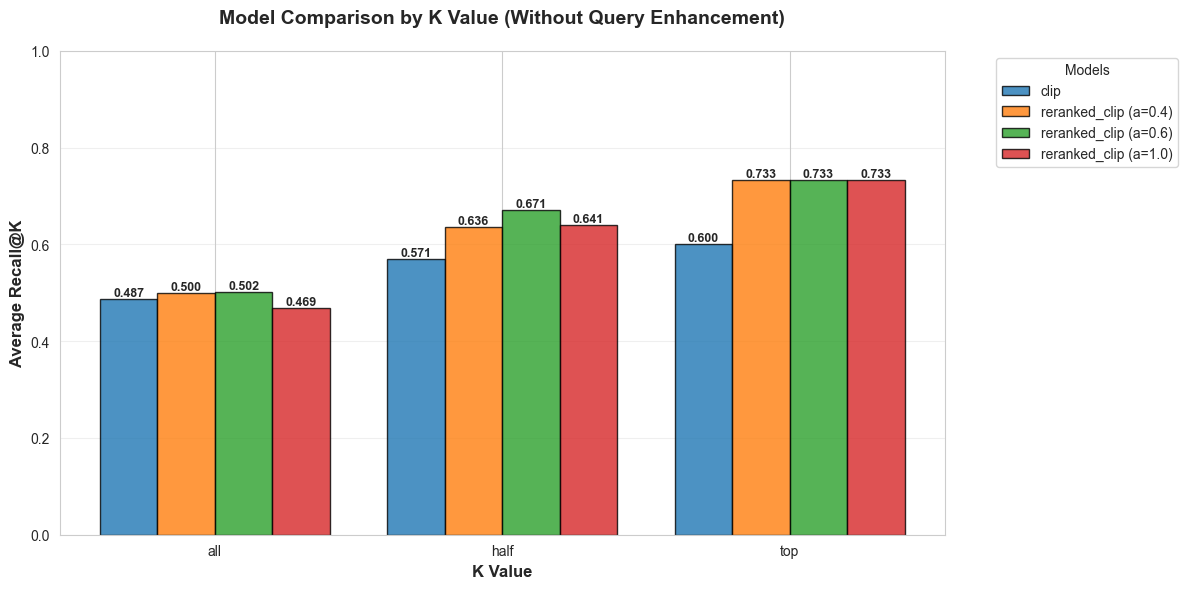


Average Recall@K by K Value (without enhancement):
model   clip  reranked_clip (a=0.4)  reranked_clip (a=0.6)  \
k                                                            
all    0.487                  0.500                  0.502   
half   0.571                  0.636                  0.671   
top    0.600                  0.733                  0.733   

model  reranked_clip (a=1.0)  
k                             
all                    0.469  
half                   0.641  
top                    0.733  


In [10]:
# Model Comparison by K Value (Without Enhancement)
# Compare models across different k values (all, half, top)

# Calculate average recall for each model-k combination
k_avg = no_enhancement.groupby(['model', 'k'])['avg_recall'].mean().reset_index()

# Pivot for plotting
k_pivot = k_avg.pivot(index='k', columns='model', values='avg_recall')

# Ensure proper ordering
k_order = ['all', 'half', 'top']
k_pivot = k_pivot.reindex(k_order)

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(k_order))
width = 0.2
models = ['clip', 'reranked_clip (a=0.4)', 'reranked_clip (a=0.6)', 'reranked_clip (a=1.0)']

# Plot bars for each model
bars_list = []
for i, model in enumerate(models):
    values = [k_pivot.loc[k, model] for k in k_order]
    bars = ax.bar(x + i*width, values, width, 
                   label=model, color=model_colors[model], 
                   alpha=0.8, edgecolor='black')
    bars_list.append(bars)
    
    # Add value labels on bars (set show_values=False to hide)
    show_values = True
    if show_values:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

# Formatting
ax.set_xlabel('K Value', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Recall@K', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison by K Value (Without Query Enhancement)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(k_order)
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)

# Add legend outside plot
ax.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Save figure
output_path = 'data/evaluation/k_value_comparison_no_enhancement.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved chart to: {output_path}")

plt.show()

# Print summary table
print("\nAverage Recall@K by K Value (without enhancement):")
print(k_pivot.round(3))

## Model Comparison (With Query Enhancement)

✓ Saved chart to: data/evaluation/overall_comparison_with_enhancement.png


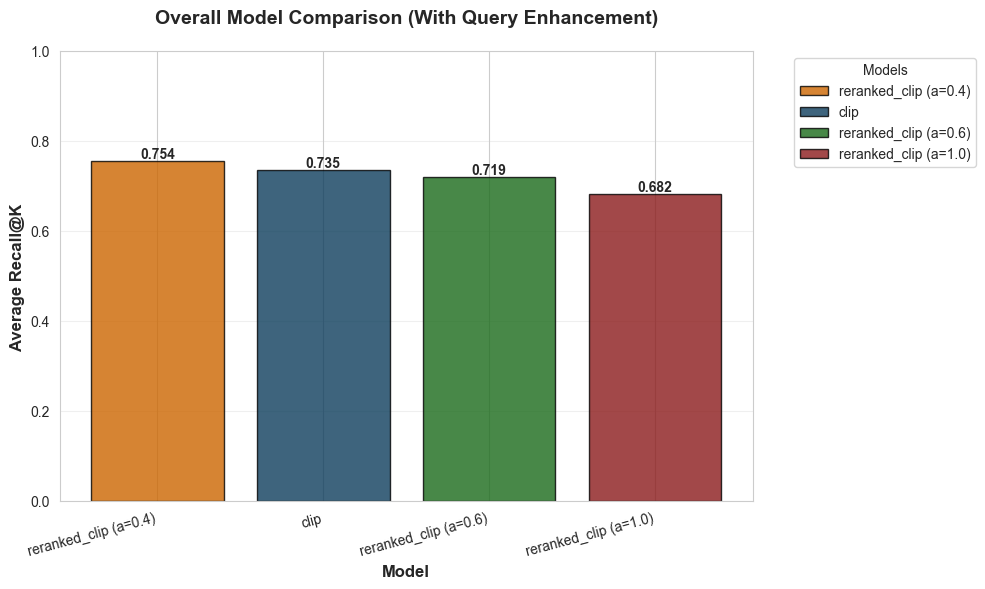


Overall Average Recall@K (with enhancement):
                model  avg_recall
reranked_clip (a=0.4)    0.754259
                 clip    0.735370
reranked_clip (a=0.6)    0.718704
reranked_clip (a=1.0)    0.681852


In [11]:
# Overall Model Comparison (With Enhancement)
# Average recall@k across ALL difficulties and k values

# Filter for with enhancement
with_enhancement = aggregated[aggregated['enhancement'] == True].copy()

# Calculate overall average for each model
overall_avg_enh = with_enhancement.groupby('model')['avg_recall'].mean().reset_index()
overall_avg_enh = overall_avg_enh.sort_values('avg_recall', ascending=False)

# Define darker colors for models (with enhancement)
model_colors_dark = {
    'clip': '#0d3d5c',
    'reranked_clip (a=0.4)': '#cc6600', 
    'reranked_clip (a=0.6)': '#1a6b1a',
    'reranked_clip (a=1.0)': '#8b1a1b'
}
colors_enh = [model_colors_dark[model] for model in overall_avg_enh['model']]

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(overall_avg_enh['model'], overall_avg_enh['avg_recall'], color=colors_enh, alpha=0.8, edgecolor='black')

# Add value labels on bars (set show_values=False to hide)
show_values = True
if show_values:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Formatting
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Recall@K', fontsize=12, fontweight='bold')
ax.set_title('Overall Model Comparison (With Query Enhancement)', fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=15, ha='right')

# Add legend outside plot
legend_labels = [f'{model}' for model in overall_avg_enh['model']]
ax.legend(bars, legend_labels, title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Save figure
output_path = 'data/evaluation/overall_comparison_with_enhancement.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved chart to: {output_path}")

plt.show()

# Print summary
print("\nOverall Average Recall@K (with enhancement):")
print(overall_avg_enh.to_string(index=False))

✓ Saved chart to: data/evaluation/difficulty_comparison_with_enhancement.png


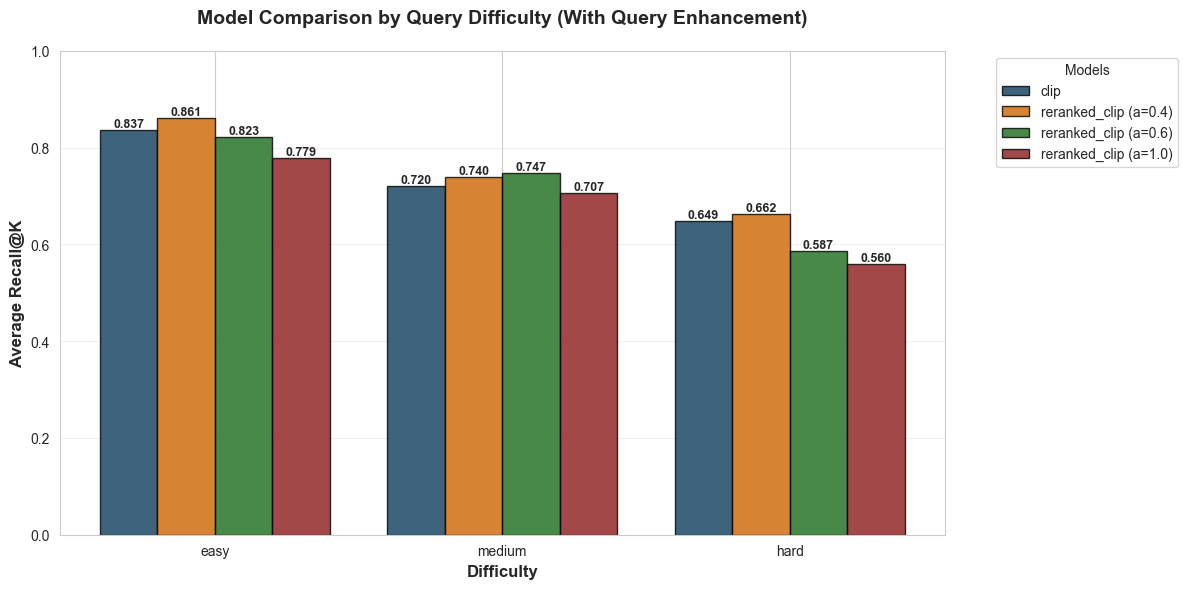


Average Recall@K by Difficulty (with enhancement):
model        clip  reranked_clip (a=0.4)  reranked_clip (a=0.6)  \
difficulty                                                        
easy        0.837                  0.861                  0.823   
medium      0.720                  0.740                  0.747   
hard        0.649                  0.662                  0.587   

model       reranked_clip (a=1.0)  
difficulty                         
easy                        0.779  
medium                      0.707  
hard                        0.560  


In [12]:
# Model Comparison by Difficulty (With Enhancement)
# Compare models across easy, medium, and hard queries

# Calculate average recall for each model-difficulty combination
difficulty_avg_enh = with_enhancement.groupby(['model', 'difficulty'])['avg_recall'].mean().reset_index()

# Pivot for plotting
difficulty_pivot_enh = difficulty_avg_enh.pivot(index='difficulty', columns='model', values='avg_recall')

# Ensure proper ordering
difficulty_order = ['easy', 'medium', 'hard']
difficulty_pivot_enh = difficulty_pivot_enh.reindex(difficulty_order)

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(difficulty_order))
width = 0.2
models = ['clip', 'reranked_clip (a=0.4)', 'reranked_clip (a=0.6)', 'reranked_clip (a=1.0)']

# Plot bars for each model
bars_list = []
for i, model in enumerate(models):
    values = [difficulty_pivot_enh.loc[diff, model] for diff in difficulty_order]
    bars = ax.bar(x + i*width, values, width, 
                   label=model, color=model_colors_dark[model], 
                   alpha=0.8, edgecolor='black')
    bars_list.append(bars)
    
    # Add value labels on bars (set show_values=False to hide)
    show_values = True
    if show_values:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

# Formatting
ax.set_xlabel('Difficulty', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Recall@K', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison by Query Difficulty (With Query Enhancement)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(difficulty_order)
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)

# Add legend outside plot
ax.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Save figure
output_path = 'data/evaluation/difficulty_comparison_with_enhancement.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved chart to: {output_path}")

plt.show()

# Print summary table
print("\nAverage Recall@K by Difficulty (with enhancement):")
print(difficulty_pivot_enh.round(3))

✓ Saved chart to: data/evaluation/k_value_comparison_with_enhancement.png


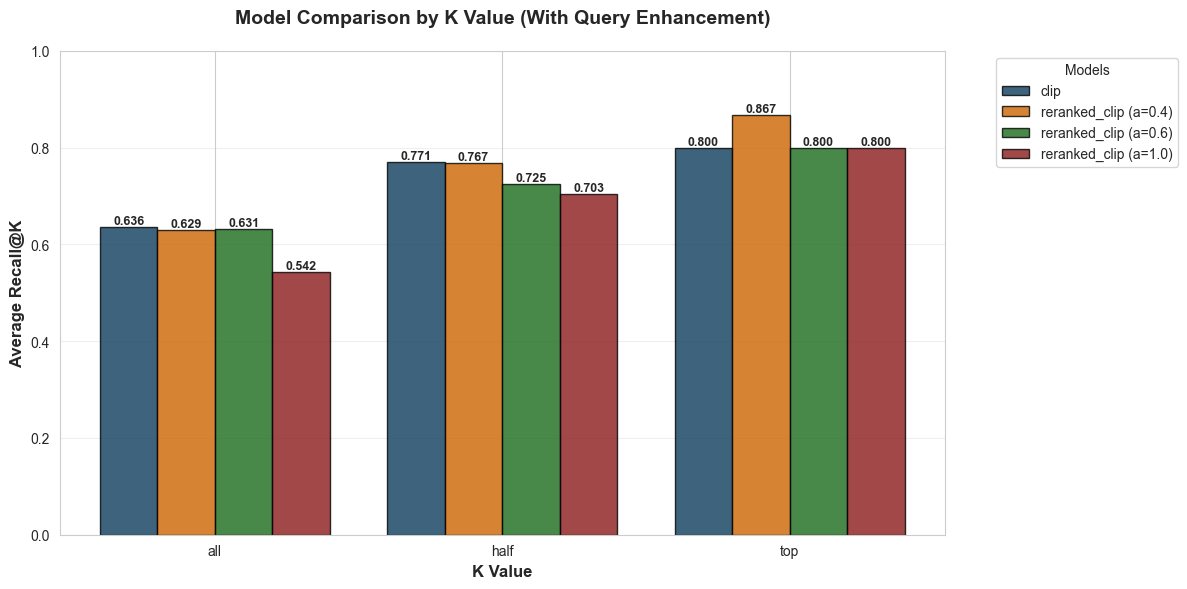


Average Recall@K by K Value (with enhancement):
model   clip  reranked_clip (a=0.4)  reranked_clip (a=0.6)  \
k                                                            
all    0.636                  0.629                  0.631   
half   0.771                  0.767                  0.725   
top    0.800                  0.867                  0.800   

model  reranked_clip (a=1.0)  
k                             
all                    0.542  
half                   0.703  
top                    0.800  


In [13]:
# Model Comparison by K Value (With Enhancement)
# Compare models across different k values (all, half, top)

# Calculate average recall for each model-k combination
k_avg_enh = with_enhancement.groupby(['model', 'k'])['avg_recall'].mean().reset_index()

# Pivot for plotting
k_pivot_enh = k_avg_enh.pivot(index='k', columns='model', values='avg_recall')

# Ensure proper ordering
k_order = ['all', 'half', 'top']
k_pivot_enh = k_pivot_enh.reindex(k_order)

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(k_order))
width = 0.2
models = ['clip', 'reranked_clip (a=0.4)', 'reranked_clip (a=0.6)', 'reranked_clip (a=1.0)']

# Plot bars for each model
bars_list = []
for i, model in enumerate(models):
    values = [k_pivot_enh.loc[k, model] for k in k_order]
    bars = ax.bar(x + i*width, values, width, 
                   label=model, color=model_colors_dark[model], 
                   alpha=0.8, edgecolor='black')
    bars_list.append(bars)
    
    # Add value labels on bars (set show_values=False to hide)
    show_values = True
    if show_values:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

# Formatting
ax.set_xlabel('K Value', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Recall@K', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison by K Value (With Query Enhancement)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(k_order)
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)

# Add legend outside plot
ax.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Save figure
output_path = 'data/evaluation/k_value_comparison_with_enhancement.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved chart to: {output_path}")

plt.show()

# Print summary table
print("\nAverage Recall@K by K Value (with enhancement):")
print(k_pivot_enh.round(3))

## Enhancement Impact Per Model

✓ Saved chart to: data/evaluation/enhancement_impact_by_difficulty.png


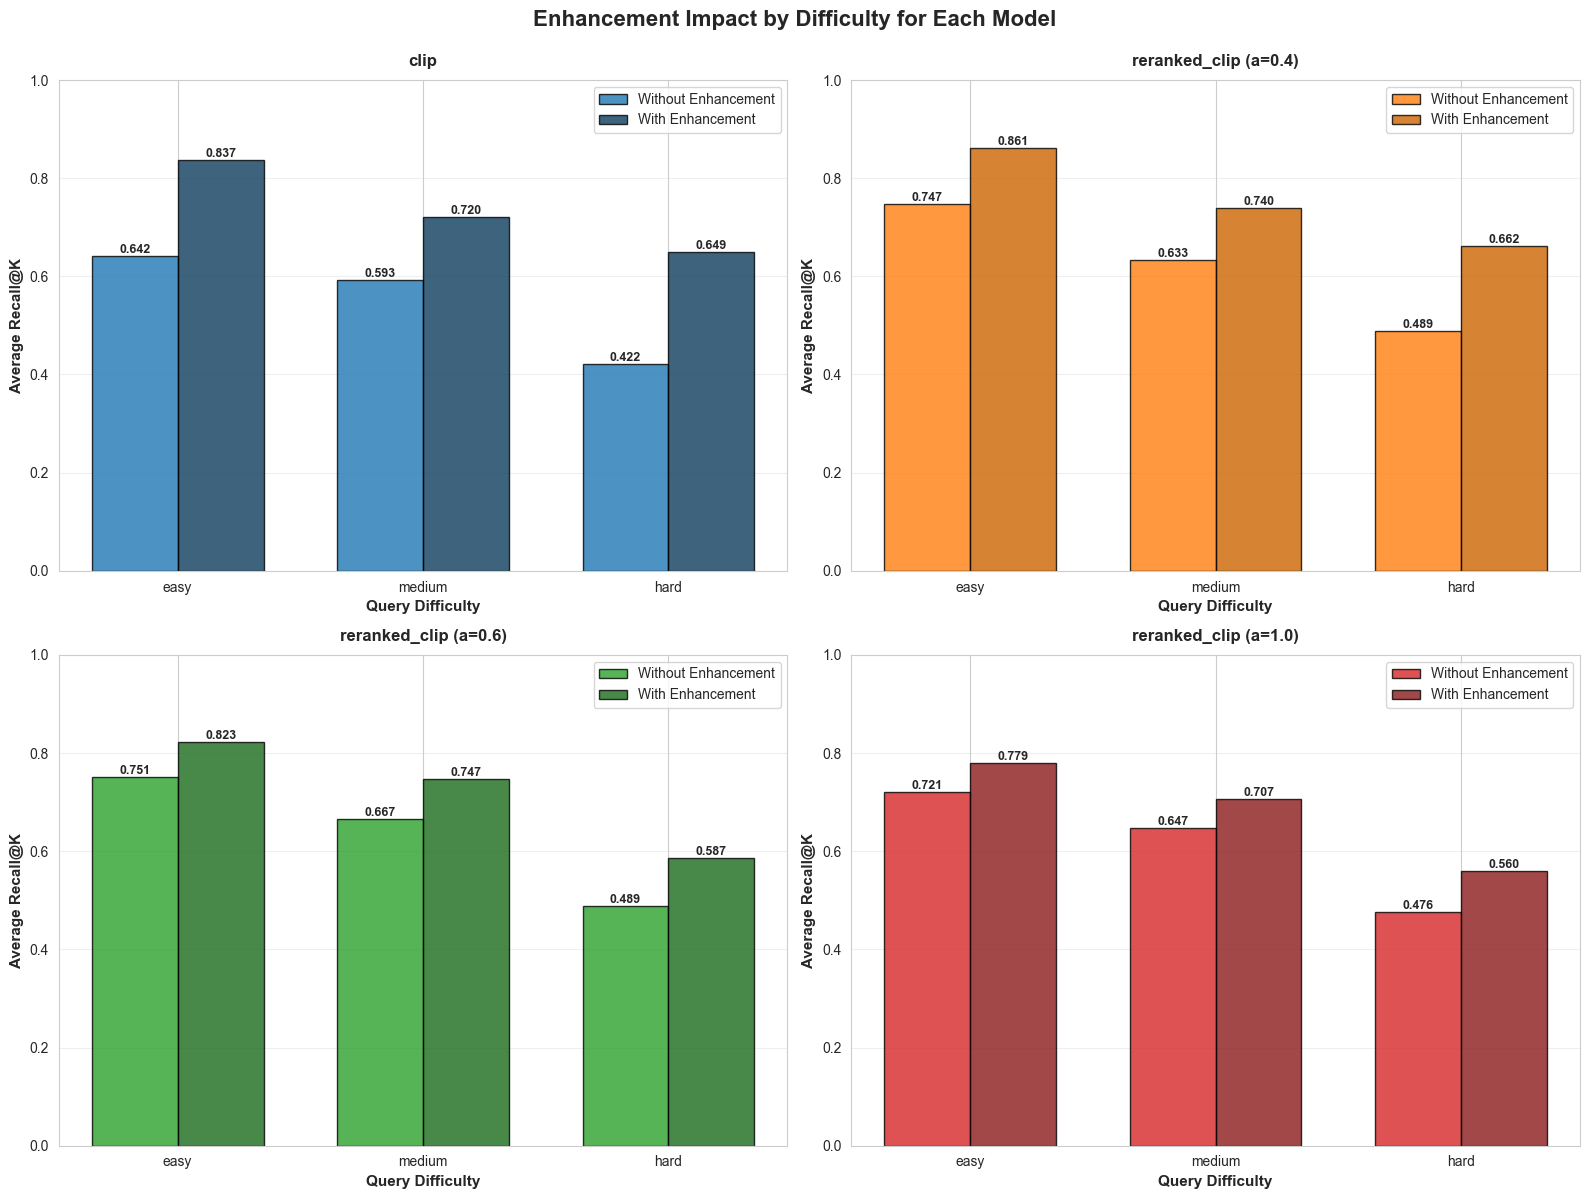


Enhancement Impact Summary (Average Recall@K by Difficulty):

clip:
            Without Enhancement  With Enhancement  Improvement
difficulty                                                    
easy                      0.642             0.837        0.196
medium                    0.593             0.720        0.127
hard                      0.422             0.649        0.227

reranked_clip (a=0.4):
            Without Enhancement  With Enhancement  Improvement
difficulty                                                    
easy                      0.747             0.861        0.114
medium                    0.633             0.740        0.107
hard                      0.489             0.662        0.173

reranked_clip (a=0.6):
            Without Enhancement  With Enhancement  Improvement
difficulty                                                    
easy                      0.751             0.823        0.072
medium                    0.667             0.747        0.080
h

In [14]:
# Enhancement Impact by Difficulty for Each Model
# Compare each model with and without query enhancement across difficulties

# Calculate average recall for each model-enhancement-difficulty combination
enhancement_impact = aggregated.groupby(['model', 'enhancement', 'difficulty'])['avg_recall'].mean().reset_index()

# Create 4 subplots (2x2 grid) - one for each model
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

models = ['clip', 'reranked_clip (a=0.4)', 'reranked_clip (a=0.6)', 'reranked_clip (a=1.0)']
difficulty_order = ['easy', 'medium', 'hard']

show_values = True

for idx, model in enumerate(models):
    ax = axes[idx]
    
    # Filter data for this model
    model_data = enhancement_impact[enhancement_impact['model'] == model]
    
    # Separate without and with enhancement
    no_enh_data = model_data[model_data['enhancement'] == False].set_index('difficulty')['avg_recall']
    with_enh_data = model_data[model_data['enhancement'] == True].set_index('difficulty')['avg_recall']
    
    # Ensure proper ordering
    no_enh_values = [no_enh_data.loc[diff] for diff in difficulty_order]
    with_enh_values = [with_enh_data.loc[diff] for diff in difficulty_order]
    
    # Create bars
    x = np.arange(len(difficulty_order))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, no_enh_values, width, 
                   label='Without Enhancement', 
                   color=model_colors[model], 
                   alpha=0.8, edgecolor='black')
    
    bars2 = ax.bar(x + width/2, with_enh_values, width, 
                   label='With Enhancement', 
                   color=model_colors_dark[model], 
                   alpha=0.8, edgecolor='black')
    
    # Add value labels on bars
    if show_values:
        for bar in bars1:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        for bar in bars2:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Formatting
    ax.set_xlabel('Query Difficulty', fontsize=11, fontweight='bold')
    ax.set_ylabel('Average Recall@K', fontsize=11, fontweight='bold')
    ax.set_title(f'{model}', fontsize=12, fontweight='bold', pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(difficulty_order)
    ax.set_ylim(0, 1.0)
    ax.grid(axis='y', alpha=0.3)
    ax.legend(loc='upper right')

plt.suptitle('Enhancement Impact by Difficulty for Each Model', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

# Save figure
output_path = 'data/evaluation/enhancement_impact_by_difficulty.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved chart to: {output_path}")

plt.show()

# Print summary table
print("\nEnhancement Impact Summary (Average Recall@K by Difficulty):")
print("="*80)
for model in models:
    print(f"\n{model}:")
    model_data = enhancement_impact[enhancement_impact['model'] == model]
    pivot = model_data.pivot(index='difficulty', columns='enhancement', values='avg_recall')
    pivot = pivot.reindex(difficulty_order)
    pivot.columns = ['Without Enhancement', 'With Enhancement']
    pivot['Improvement'] = pivot['With Enhancement'] - pivot['Without Enhancement']
    print(pivot.round(3))

✓ Saved chart to: data/evaluation/best_configuration_comparison.png


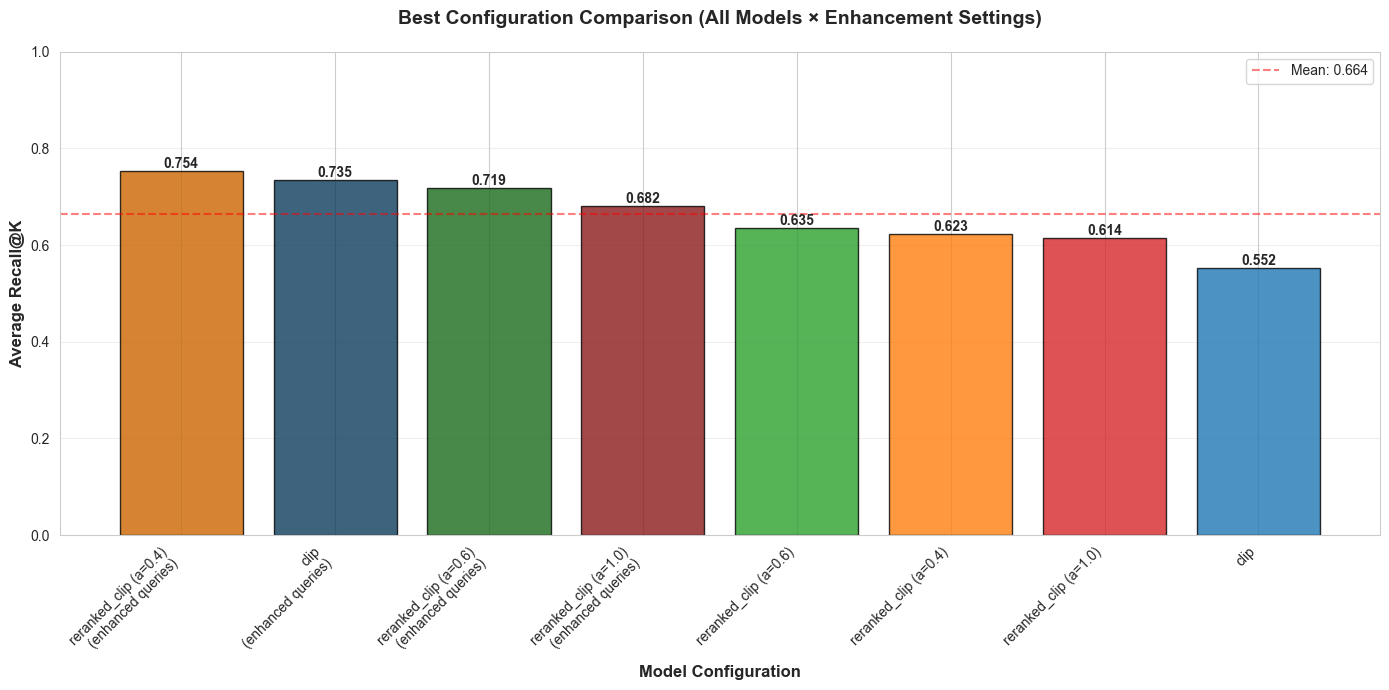


All Configuration Rankings (by Average Recall@K):
 Rank                             Configuration  Average Recall@K
    1 reranked_clip (a=0.4)\n(enhanced queries)          0.754259
    2                  clip\n(enhanced queries)          0.735370
    3 reranked_clip (a=0.6)\n(enhanced queries)          0.718704
    4 reranked_clip (a=1.0)\n(enhanced queries)          0.681852
    5                     reranked_clip (a=0.6)          0.635370
    6                     reranked_clip (a=0.4)          0.622963
    7                     reranked_clip (a=1.0)          0.614259
    8                                      clip          0.552407

✓ Best Configuration: reranked_clip (a=0.4) (enhanced queries) with 0.754 average recall@k
✓ Mean across all configurations: 0.664


In [15]:
# Overall Best Configuration Comparison
# Compare all model configurations (4 models × 2 enhancement settings = 8 configurations)

# Calculate overall average for each model-enhancement combination
all_configs = aggregated.groupby(['model', 'enhancement'])['avg_recall'].mean().reset_index()

# Create configuration labels and prepare data
models = ['clip', 'reranked_clip (a=0.4)', 'reranked_clip (a=0.6)', 'reranked_clip (a=1.0)']
config_labels = []
config_values = []
config_colors = []

for model in models:
    # Without enhancement - just use model name
    no_enh_data = all_configs[(all_configs['model'] == model) & (all_configs['enhancement'] == False)]
    if len(no_enh_data) > 0:
        no_enh_val = no_enh_data['avg_recall'].values[0]
        config_labels.append(model)
        config_values.append(no_enh_val)
        config_colors.append(model_colors[model])

    # With enhancement - add "(enhanced queries)"
    with_enh_data = all_configs[(all_configs['model'] == model) & (all_configs['enhancement'] == True)]
    if len(with_enh_data) > 0:
        with_enh_val = with_enh_data['avg_recall'].values[0]
        config_labels.append(f'{model}\n(enhanced queries)')
        config_values.append(with_enh_val)
        config_colors.append(model_colors_dark[model])

# Sort by performance
sorted_indices = np.argsort(config_values)[::-1]  # Descending order
config_labels_sorted = [config_labels[i] for i in sorted_indices]
config_values_sorted = [config_values[i] for i in sorted_indices]
config_colors_sorted = [config_colors[i] for i in sorted_indices]

# Create plot
fig, ax = plt.subplots(figsize=(14, 7))

bars = ax.bar(range(len(config_labels_sorted)), config_values_sorted, 
               color=config_colors_sorted, alpha=0.8, edgecolor='black')

# Add value labels on bars
show_values = True
if show_values:
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Formatting
ax.set_xlabel('Model Configuration', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Recall@K', fontsize=12, fontweight='bold')
ax.set_title('Best Configuration Comparison (All Models × Enhancement Settings)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(range(len(config_labels_sorted)))
ax.set_xticklabels(config_labels_sorted, rotation=45, ha='right', fontsize=10)
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)

# Add a horizontal line at the mean
mean_recall = np.mean(config_values_sorted)
ax.axhline(y=mean_recall, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label=f'Mean: {mean_recall:.3f}')
ax.legend(loc='upper right')

plt.tight_layout()

# Save figure
output_path = 'data/evaluation/best_configuration_comparison.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved chart to: {output_path}")

plt.show()

# Print summary table
print("\nAll Configuration Rankings (by Average Recall@K):")
print("="*80)
ranking_df = pd.DataFrame({
    'Rank': range(1, len(config_labels_sorted) + 1),
    'Configuration': config_labels_sorted,
    'Average Recall@K': config_values_sorted
})
print(ranking_df.to_string(index=False))

print(f"\n✓ Best Configuration: {config_labels_sorted[0].replace(chr(10), ' ')} with {config_values_sorted[0]:.3f} average recall@k")
print(f"✓ Mean across all configurations: {mean_recall:.3f}")

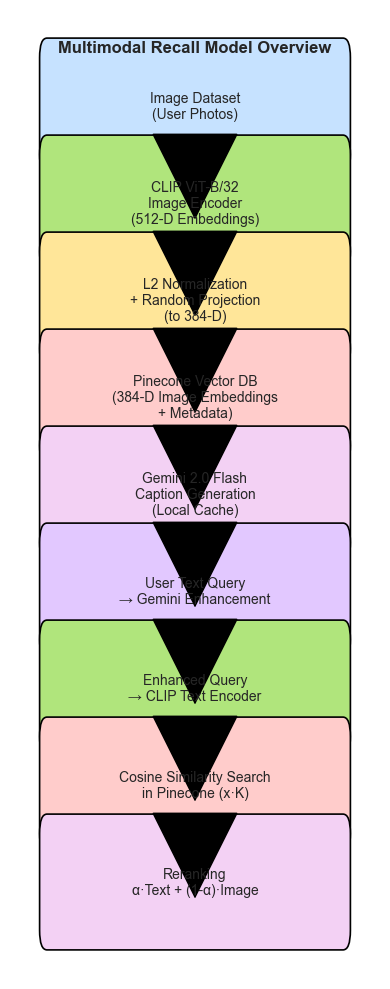

In [33]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, ArrowStyle

# Create figure
fig, ax = plt.subplots(figsize=(4,10))  # thin and tall
ax.axis('off')

# Helper function to draw labeled cubes
def draw_box(y, text, color='#A7C7E7'):
    ax.add_patch(FancyBboxPatch((0.1, y), 0.8, 0.1, boxstyle="round,pad=0.02", fc=color, ec='black', lw=1.2))
    ax.text(0.5, y+0.05, text, ha='center', va='center', fontsize=10, wrap=True)

def draw_arrow(y1, y2):
    ax.annotate('', xy=(0.5, y2), xytext=(0.5, y1), arrowprops=dict(arrowstyle=ArrowStyle("-|>", head_length=6, head_width=3), lw=1.2, color='black'))

# Draw components
draw_box(0.85, 'Image Dataset\n(User Photos)', '#C6E2FF')
draw_arrow(0.85, 0.78)

draw_box(0.75, 'CLIP ViT-B/32\nImage Encoder\n(512-D Embeddings)', '#B0E57C')
draw_arrow(0.75, 0.68)

draw_box(0.65, 'L2 Normalization\n+ Random Projection\n(to 384-D)', '#FFE699')
draw_arrow(0.65, 0.58)

draw_box(0.55, 'Pinecone Vector DB\n(384-D Image Embeddings\n+ Metadata)', '#FFCCCB')
draw_arrow(0.55, 0.48)

draw_box(0.45, 'Gemini 2.0 Flash\nCaption Generation\n(Local Cache)', '#F3D1F4')
draw_arrow(0.45, 0.38)

draw_box(0.35, 'User Text Query\n→ Gemini Enhancement', '#E2C8FF')
draw_arrow(0.35, 0.28)

draw_box(0.25, 'Enhanced Query\n→ CLIP Text Encoder', '#B0E57C')
draw_arrow(0.25, 0.18)

draw_box(0.15, 'Cosine Similarity Search\nin Pinecone (x·K)', '#FFCCCB')
draw_arrow(0.15, 0.08)

draw_box(0.05, 'Reranking\nα·Text + (1-α)·Image', '#F3D1F4')

# Title
ax.text(0.5, 0.96, 'Multimodal Recall Model Overview', ha='center', va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()